# Run test prompt on an image

In [16]:
import httpx

ENDPOINT_URL = "https://cerebella-org--sgl-vlm-model-generate.modal.run"

payload = {
    "image_url": "https://www.maxcembalest.com/personal/max_tokyo_full.jpg",
    "text": "where in the world is this guy?"
}
response = httpx.post(ENDPOINT_URL, json=payload, timeout=100)

In [17]:
response.json()

'The background of the image shows a cityscape with tall buildings, likely indicating that the photo was taken in a densely populated urban area. The architecture and layout of the buildings resemble Japanese residential and commercial styles, common in Tokyo or other large Japanese cities. Given the presence of what looks like traditional or bonsai trees, it is possible that the location might be in or near Tokyo, which is renowned for its blend of traditional and modern architecture.'

# Benchmarking Concurrent Modal Endpoint Requests

In [1]:
import json
import re
import os
import requests
from PIL import Image
from io import BytesIO
from transformers import AutoProcessor
from qwen_vl_utils import process_vision_info

with open("test.jsonl") as f:
    QUESTION_DATA = [json.loads(x) for x in list(f)]

DATASET_URL = "https://raw.githubusercontent.com/mathllm/MATH-V/refs/heads/main/images"
IMAGES_DIR = "downloaded_images"

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

/Users/maxcembalest/Desktop/repos/mathvision/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


In [2]:
def download_image(image_num: int) -> str:
    os.makedirs(IMAGES_DIR, exist_ok=True)
    local_path = os.path.join(IMAGES_DIR, f"{image_num}.jpg")
    
    if not os.path.exists(local_path):
        url = f"{DATASET_URL}/{image_num}.jpg"
        response = requests.get(url)
        response.raise_for_status()
        with open(local_path, "wb") as f:
            f.write(response.content)
        print(f"Downloaded image {image_num}")
    
    return local_path

def format_question(question: str) -> str:
    question = re.sub(r"\n?<image\d+>", "", question)
    return f"Think, and then answer with a single number or letter. Place your thinking between <thinking> and </thinking> tags and then answer between <answer> and </answer> tags. {question}"

def count_tokens_for_question(image_num: int, question: str) -> dict:
    """Compute token count for a question with its image."""
    image_path = download_image(image_num)    
    formatted_question = format_question(question)    
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": f"file://{os.path.abspath(image_path)}"},
                {"type": "text", "text": formatted_question},
            ],
        }
    ]    
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )    
    input_ids = inputs["input_ids"]
    num_tokens = input_ids.shape[1]

    return num_tokens

In [3]:
N = 64
results = []
for i in range(1, N + 1):
    question = QUESTION_DATA[i - 1]["question"]
    result_total_tokens = count_tokens_for_question(i, question)
    results.append(result_total_tokens)
    print(f"Q{i}: {result_total_tokens} tokens")


Q1: 322 tokens
Q2: 676 tokens
Q3: 881 tokens
Q4: 179 tokens
Q5: 541 tokens
Q6: 1461 tokens
Q7: 195 tokens
Q8: 250 tokens
Q9: 1882 tokens
Q10: 245 tokens
Q11: 280 tokens
Q12: 216 tokens
Q13: 642 tokens
Q14: 292 tokens
Q15: 230 tokens
Q16: 135 tokens
Q17: 186 tokens
Q18: 200 tokens
Q19: 262 tokens
Q20: 290 tokens
Q21: 1467 tokens
Q22: 156 tokens
Q23: 211 tokens
Q24: 282 tokens
Q25: 254 tokens
Q26: 960 tokens
Q27: 765 tokens
Q28: 310 tokens
Q29: 377 tokens
Q30: 1719 tokens
Q31: 1419 tokens
Q32: 985 tokens
Q33: 3238 tokens
Q34: 1754 tokens
Q35: 638 tokens
Q36: 315 tokens
Q37: 2496 tokens
Q38: 271 tokens
Q39: 469 tokens
Q40: 1093 tokens
Q41: 343 tokens
Q42: 1776 tokens
Q43: 413 tokens
Q44: 2201 tokens
Q45: 1205 tokens
Q46: 2117 tokens
Q47: 332 tokens
Q48: 1516 tokens
Q49: 723 tokens
Q50: 1545 tokens
Q51: 222 tokens
Q52: 271 tokens
Q53: 903 tokens
Q54: 496 tokens
Q55: 287 tokens
Q56: 1303 tokens
Q57: 572 tokens
Q58: 2395 tokens
Q59: 2338 tokens
Q60: 2186 tokens
Q61: 248 tokens
Q62: 341 token

In [4]:
print(f"\n--- Summary for first {N} questions ---")
total_tokens = sum(results)
print(f"Total tokens: {total_tokens:,}")
print(f"Average tokens per question: {total_tokens / len(results):,.1f}")
print(f"Min tokens: {min(results)}")
print(f"Max tokens: {max(results)}")


--- Summary for first 64 questions ---
Total tokens: 53,909
Average tokens per question: 842.3
Min tokens: 135
Max tokens: 3238


In [ ]:
import subprocess
import time
import numpy as np

def run_benchmark(concurrency: int, start: int = 1, end: int = 64) -> float:
    """Run the benchmark and return elapsed time in seconds."""
    start_time = time.time()
    subprocess.run(
        ["python", "test_endpoint_concurrent.py", 
         "--start", str(start), "--end", str(end), "--concurrency", str(concurrency)],
        capture_output=True
    )
    return time.time() - start_time

concurrencies = [8, 16, 24, 32, 48, 64]
num_trials = 5

results = {c: [] for c in concurrencies}

for trial in range(1, num_trials + 1):
    print(f"=== Trial {trial}/{num_trials} ===")
    for c in concurrencies:
        elapsed = run_benchmark(c)
        results[c].append(elapsed)
        print(f"  concurrency={c}: {elapsed:.2f}s")

print(f"{'Concurrency':<12} {'Mean (s)':<10} {'Std (s)':<10} {'Min (s)':<10} {'Max (s)':<10} {'Throughput (req/s)':<10}")
print("-" * 70)

stats = []
for c in concurrencies:
    times = results[c]
    mean_time = np.mean(times)
    std_time = np.std(times)
    min_time = np.min(times)
    max_time = np.max(times)
    throughput = total_tokens / mean_time
    stats.append({
        "concurrency": c,
        "mean_time": mean_time,
        "std_time": std_time,
        "throughput": throughput
    })
    print(f"{c:<12} {mean_time:<10.2f} {std_time:<10.2f} {min_time:<10.2f} {max_time:<10.2f} {throughput:<10.2f}")

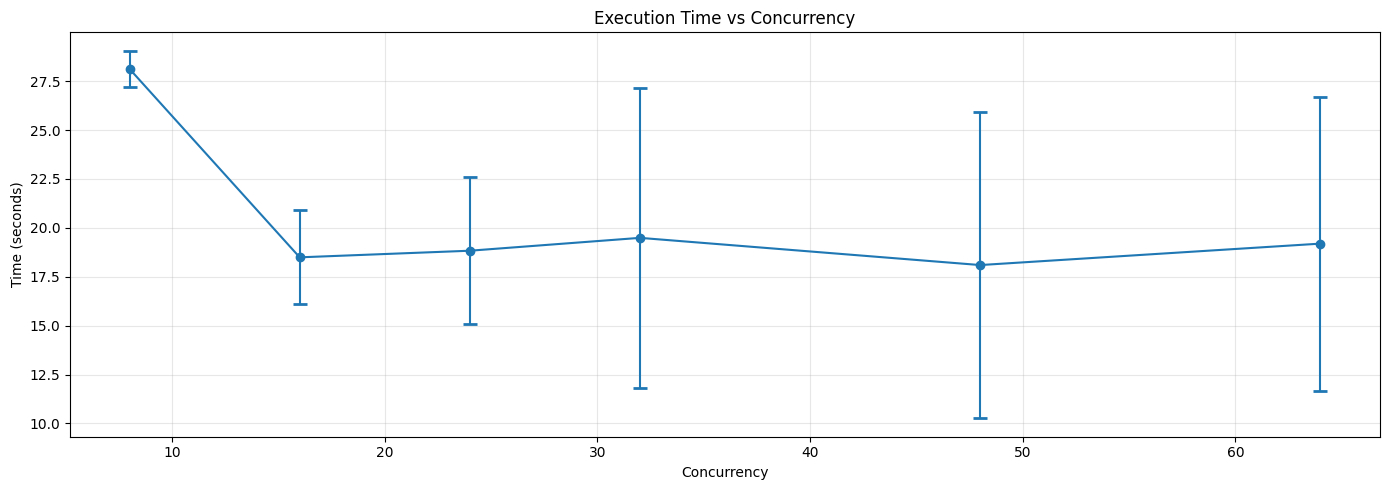

In [ ]:
import matplotlib.pyplot as plt

conc_list = [s["concurrency"] for s in stats]
means = [s["mean_time"] for s in stats]
stds = [s["std_time"] for s in stats]

fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.errorbar(conc_list, means, yerr=stds, marker='o', capsize=5, capthick=2)
ax.set_xlabel('Concurrency')
ax.set_ylabel('Time (seconds)')
ax.set_title('Execution Time vs Concurrency')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()